# Taller 2, detección de errores de manufactura
### David Buitrago, Carlos Galán

# Aplicación en detección de imperfecciones en cables de cobre

Este proyecto tiene como objetivo desarrollar un sistema de clasificación para detectar imperfecciones en cables de cobre utilizando técnicas de visión por computadora y aprendizaje automático. A continuación se desarrollan las etapas del proceso:

---

## The MVTec anomaly detection dataset (MVTec AD)

## 1. Carga y Preprocesamiento de Imágenes
Se implementaron funciones para cargar imágenes desde carpetas y aplicar preprocesamiento básico, como la ecualización del histograma, para mejorar la calidad visual de las imágenes y resaltar características importantes.

### Funciones principales:
- **Lectura de imágenes desde carpetas**: Permite cargar imágenes organizadas por clases (`good` y `bad`).

## Carga y Preprocesamiento

In [40]:
import cv2
import os

### Lectura de imágenes desde carpetas

In [41]:
train_dir = r"cable\train"

def read_images_from_folder(folder_path):    
    if not os.path.exists(train_dir):        
        print("El directorio de entrenamiento no existe.")
    else:
        for subfolder in os.listdir(train_dir):
            subfolder_path = os.path.join(train_dir, subfolder)
            if os.path.isdir(subfolder_path):
                print(f"Clase: {subfolder}, Número de imágenes: {len(os.listdir(subfolder_path))}")\

read_images_from_folder(train_dir)

Clase: bent_wire, Número de imágenes: 13
Clase: cable_swap, Número de imágenes: 12
Clase: combined, Número de imágenes: 11
Clase: cut_inner_insulation, Número de imágenes: 14
Clase: cut_outer_insulation, Número de imágenes: 10
Clase: good, Número de imágenes: 224
Clase: missing_cable, Número de imágenes: 12
Clase: missing_wire, Número de imágenes: 10
Clase: poke_insulation, Número de imágenes: 10


In [42]:
test_dir = r"cable\test"
read_images_from_folder(test_dir)

Clase: bent_wire, Número de imágenes: 13
Clase: cable_swap, Número de imágenes: 12
Clase: combined, Número de imágenes: 11
Clase: cut_inner_insulation, Número de imágenes: 14
Clase: cut_outer_insulation, Número de imágenes: 10
Clase: good, Número de imágenes: 224
Clase: missing_cable, Número de imágenes: 12
Clase: missing_wire, Número de imágenes: 10
Clase: poke_insulation, Número de imágenes: 10


## Función de ecualización

- **Ecualización del histograma**: Mejora el contraste de las imágenes para facilitar la detección de características relevantes.

In [43]:
# Función para ecualizar el histograma de una imagen
def equalize_histogram(image):
    # Convertir la imagen a espacio de color YUV
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Ecualizar el canal de luminancia (Y)
    yuv_image[:, :, 0] = cv2.equalizeHist(yuv_image[:, :, 0])
    # Convertir de nuevo a BGR
    equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)
    return equalized_image


### Carga de imágenes (ecualizadas)

In [44]:
# Modificar la función de carga para ecualizar las imágenes
def load_images_and_labels(dir_path):
    data = []
    labels = []
    for subfolder in os.listdir(dir_path):
        subfolder_path = os.path.join(dir_path, subfolder)
        if os.path.isdir(subfolder_path):
            for image_file in os.listdir(subfolder_path):
                if image_file.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(subfolder_path, image_file)
                    image = cv2.imread(image_path)
                    # Aplicar ecualización de histograma
                    image = equalize_histogram(image)
                    data.append(image)
                    labels.append(subfolder)
    print(f"Se cargaron {len(data)} imágenes con sus etiquetas (ecualizadas).")
    return data, labels

In [45]:
train_data, train_labels=load_images_and_labels(train_dir)
test_data, test_labels=load_images_and_labels(test_dir)

Se cargaron 316 imágenes con sus etiquetas (ecualizadas).
Se cargaron 150 imágenes con sus etiquetas (ecualizadas).


## 2. Aumento de Datos (*Data Augmentation*)
Para abordar el problema de desequilibrio en las clases y aumentar la diversidad del conjunto de datos, se utilizó un generador de imágenes que aplica transformaciones como rotaciones, desplazamientos y reflexiones horizontales.

### Beneficios:
- Incrementa el tamaño del conjunto de datos.
- Mejora la capacidad de generalización de los modelos.


### Generador de imágenes

In [46]:
import os
import random
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

# Directorio donde se guardarán las imágenes generadas
augmented_dir = r"cable\train_augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Configurar el generador de imágenes
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_save_images(data_train, labels_train, augmented_dir):
    # Contar las imágenes por clase
    class_counts = Counter(labels_train)
    max_count = max(class_counts.values())  # Número máximo de imágenes en una clase

    for label in class_counts:
        # Crear una carpeta para cada clase
        class_dir = os.path.join(augmented_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Verificar si ya existen imágenes generadas
        existing_images = os.listdir(class_dir)
        if len(existing_images) >= max_count:
            print(f"Imágenes para la clase '{label}' ya generadas. Saltando...")
            continue

        # Obtener imágenes de la clase
        class_images = [data_train[i] for i in range(len(labels_train)) if labels_train[i] == label]
        count = len(existing_images)

        # Generar imágenes hasta alcanzar el máximo
        while count < max_count:
            image = random.choice(class_images)
            image = cv2.resize(image, (224, 224))  # Redimensionar si es necesario
            image = np.expand_dims(image, axis=0)  # Expandir dimensiones para el generador

            for batch in datagen.flow(image, batch_size=1):
                save_path = os.path.join(class_dir, f"aug_{count}.jpg")
                cv2.imwrite(save_path, batch[0].astype('uint8'))  # Guardar directamente en disco
                count += 1
                if count >= max_count:
                    break

        print(f"Imágenes aumentadas guardadas para la clase '{label}' en: {class_dir}")

# Llamar a la función
augment_and_save_images(train_data, train_labels, augmented_dir)

Imágenes para la clase 'bent_wire' ya generadas. Saltando...
Imágenes para la clase 'cable_swap' ya generadas. Saltando...
Imágenes para la clase 'combined' ya generadas. Saltando...
Imágenes para la clase 'cut_inner_insulation' ya generadas. Saltando...
Imágenes para la clase 'cut_outer_insulation' ya generadas. Saltando...
Imágenes para la clase 'good' ya generadas. Saltando...
Imágenes para la clase 'missing_cable' ya generadas. Saltando...
Imágenes para la clase 'missing_wire' ya generadas. Saltando...
Imágenes para la clase 'poke_insulation' ya generadas. Saltando...


In [47]:
len(train_data)

316

### Almacenamiento de imágenes aumentadas

In [48]:
def combine_original_and_augmented(train_dir, augmented_dir):
    # Listas para almacenar las imágenes y etiquetas combinadas
    combined_data = []
    combined_labels = []

    # Cargar imágenes originales
    for subfolder in os.listdir(train_dir):
        subfolder_path = os.path.join(train_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for image_file in os.listdir(subfolder_path):
                if image_file.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(subfolder_path, image_file)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (224, 224))  # Redimensionar si es necesario
                    combined_data.append(image)
                    combined_labels.append(subfolder)

    # Cargar imágenes aumentadas
    for subfolder in os.listdir(augmented_dir):
        subfolder_path = os.path.join(augmented_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for image_file in os.listdir(subfolder_path):
                if image_file.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(subfolder_path, image_file)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (224, 224))  # Redimensionar si es necesario
                    combined_data.append(image)
                    combined_labels.append(subfolder)

    print(f"Dataset combinado: {len(combined_data)} imágenes en total.")
    return combined_data, combined_labels

# Llamar a la función para combinar los datasets
# train_data, train_labels = combine_original_and_augmented(train_dir, augmented_dir)

## Visualización de keypoints en una imagen con error

In [49]:
# Función para buscar imágenes en una categoría específica
def read_images_by_category(folder_path, category):
    """
    Carga imágenes de una categoría específica desde un directorio.

    Args:
        folder_path (str): Ruta del directorio principal.
        category (str): Nombre de la categoría a buscar.

    Returns:
        list: Lista de imágenes cargadas.
    """
    category_path = os.path.join(folder_path, category)
    
    if not os.path.exists(category_path):
        print(f"La categoría '{category}' no existe en el directorio proporcionado.")
        return []
    
    images = []
    for image_file in os.listdir(category_path):
        if image_file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)
            images.append(image)
    
    print(f"Se encontraron {len(images)} imágenes en la categoría '{category}'.")
    return images

# Ejemplo de uso
test_dir = r"cable\\test"
category = "missing_cable"  # Cambiar por la categoría deseada
images = read_images_by_category(test_dir, category)

Se encontraron 12 imágenes en la categoría 'missing_cable'.


Se encontraron 12 imágenes en la categoría 'missing_cable'.
Se encontraron 11 imágenes en la categoría 'combined'.
Se encontraron 58 imágenes en la categoría 'good'.


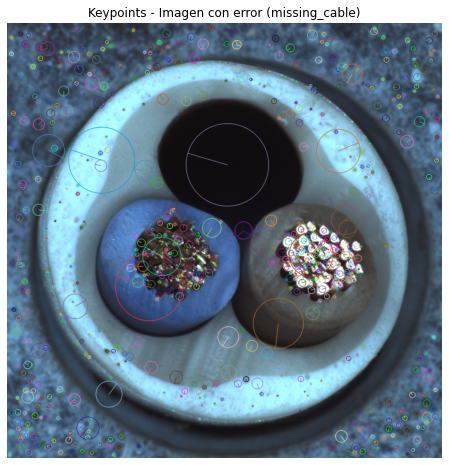

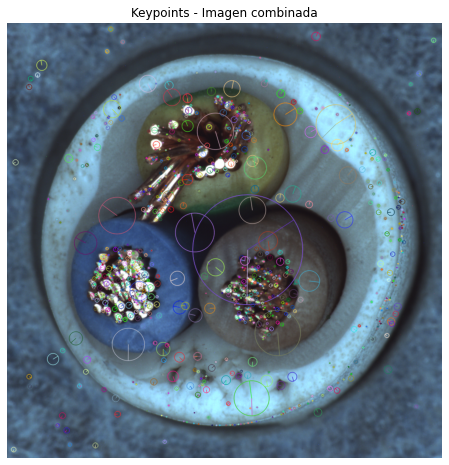

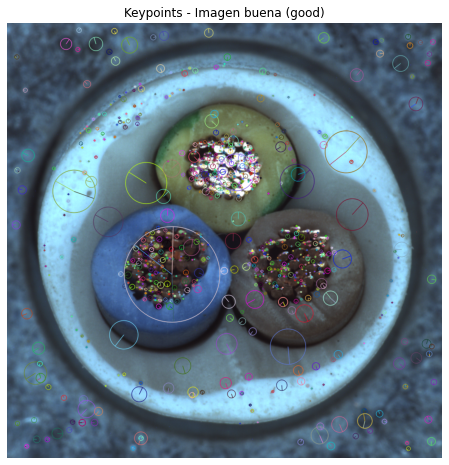

In [50]:
import cv2
import matplotlib.pyplot as plt

# Función para visualizar los keypoints detectados por SIFT
def visualize_keypoints(image, title):
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Crear el detector SIFT
    sift = cv2.SIFT_create()
    
    # Detectar keypoints
    keypoints = sift.detect(gray_image, None)
    
    # Dibujar los keypoints en la imagen
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Convertir la imagen a RGB para visualización con matplotlib
    image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    
    # Mostrar la imagen con keypoints
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_keypoints_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Cargar imágenes de la categoría 'missing_cable'
missing_cable_images = read_images_by_category(test_dir, "missing_cable")
combined_images = read_images_by_category(test_dir, "combined")
good_images = read_images_by_category(test_dir, "good")
# Asegurarse de que hay imágenes disponibles
if missing_cable_images:
    # Seleccionar la primera imagen de la categoría 'missing_cable'
    error_image1 = missing_cable_images[0]
    error_image2 = combined_images[0]
    good_image = good_images[0]
    
    # Visualizar los keypoints
    visualize_keypoints(error_image1, "Keypoints - Imagen con error (missing_cable)")
    visualize_keypoints(error_image2, "Keypoints - Imagen combinada")
    visualize_keypoints(good_image, "Keypoints - Imagen buena (good)")
else:
    print("No se encontraron imágenes en la categoría 'missing_cable'.")

# Análisis de Keypoints en la Imagen con Error `missing_cable`
---

### **1. Distribución de Keypoints**
- **Regiones con cables presentes**:
  - Los keypoints están densamente distribuidos en las áreas donde los cables están presentes.
  - Se concentran en los bordes y texturas internas de los cables, lo que indica que SIFT detecta características visuales significativas en estas regiones.
  
- **Región sin cable (vacía)**:
  - En la zona donde falta el cable (área negra), se detectan pocos o ningún keypoint.
  - Esto es consistente con la ausencia de características visuales significativas en esta región.

### **2. Tamaño de los Keypoints**
- Los keypoints detectados varían en tamaño, lo que indica que SIFT está capturando características a diferentes escalas.
- Los keypoints más grandes suelen estar asociados con estructuras más prominentes, como los bordes de los cables.

## **Implicaciones para la Clasificación**
1. **Región sin cable**:
   - La ausencia de keypoints en la región vacía puede ser utilizada como una característica distintiva para clasificar imágenes con el error `missing_cable`.

2. **Regiones con cables**:
   - La alta densidad de keypoints en las áreas con cables puede confirmar la presencia de cables y diferenciar entre imágenes con y sin errores.

In [51]:
train_labels = ['good' if label == 'good' else 'bad' for label in train_labels]
print("Etiquetas modificadas en train_labels:", set(train_labels))
test_labels = ['good' if label == 'good' else 'bad' for label in test_labels]
print("Etiquetas modificadas en test_labels:", set(test_labels))

Etiquetas modificadas en train_labels: {'bad', 'good'}
Etiquetas modificadas en test_labels: {'bad', 'good'}


## 3. Construcción del Pipeline de Clasificación
Se diseñó un pipeline que incluye las siguientes etapas:
1. **Extracción de características SIFT**: Detecta puntos clave y descriptores en las imágenes.
2. **Construcción de vocabulario visual**: Agrupa descriptores en clústeres utilizando *K-Means*.
3. **Transformación TF-IDF**: Calcula la importancia de los descriptores en el vocabulario.
4. **Clasificación**: Se probaron tres modelos principales:
   - **XGBoost (XGB)**
   - **Random Forest (RF)**
   - **Máquinas de Soporte Vectorial (SVM)**

---

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Codificar etiquetas numéricas
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_test_labels  = label_encoder.transform(test_labels)

# 1. Clase para extracción de descriptores SIFT
class SIFTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sift = cv2.SIFT_create()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        descriptors_list = []
        for img in X:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, descriptors = self.sift.detectAndCompute(gray, None)
            if descriptors is not None:
                descriptors_list.append(descriptors)
        return descriptors_list

# 2. Clase para construir el vocabulario visual
class VisualVocabulary(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=100):
        self.n_clusters = n_clusters
        self.kmeans = None
    def fit(self, X, y=None):
        all_descriptors = np.vstack(X)
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(all_descriptors)
        return self
    def transform(self, X):
        histograms = []
        for descriptors in X:
            if descriptors is not None:
                words = self.kmeans.predict(descriptors)
                histogram, _ = np.histogram(words, bins=np.arange(self.n_clusters + 1))
                histograms.append(histogram)
            else:
                histograms.append(np.zeros(self.n_clusters))
        return np.array(histograms)

# Definición de los modelos a probar
models = {
    'xgb': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'svm': SVC(probability=True, random_state=42)
}

best_models = {}
for name, clf in models.items():
    print(f"\nProbando modelo: {name}")
    pipeline = Pipeline([
        ('sift_extractor', SIFTFeatureExtractor()),
        ('vocabulary', VisualVocabulary(n_clusters=100)),
        ('tfidf', TfidfTransformer()),
        ('scaler', StandardScaler(with_mean=False)),  # Evitar error en datos dispersos
        ('classifier', clf)
    ])
    pipeline.fit(train_data, encoded_train_labels)
    score = pipeline.score(test_data, encoded_test_labels)
    print(f"Precisión para el modelo {name}: {score:.2f}")
    best_models[name] = pipeline


Probando modelo: xgb
Precisión para el modelo xgb: 0.92

Probando modelo: rf
Precisión para el modelo rf: 0.95

Probando modelo: svm
Precisión para el modelo svm: 0.83


## 4. Evaluación de Modelos
Se evaluaron los modelos utilizando métricas como la precisión, el *recall* y el F1-score. Además, se generaron curvas ROC para analizar el desempeño de los clasificadores.

## Curva ROC

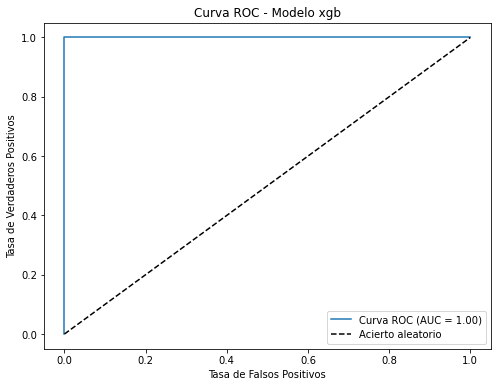

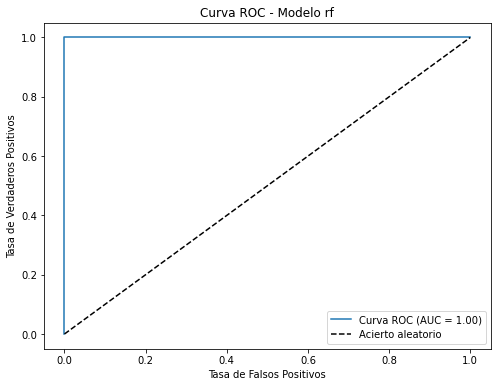

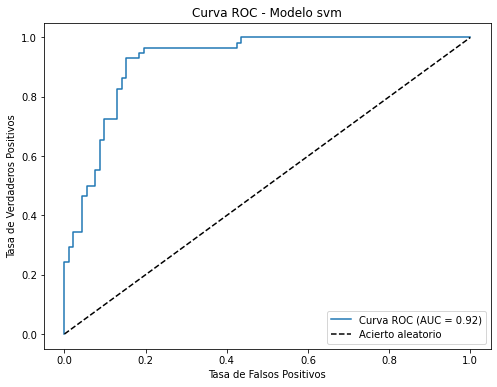

In [53]:
def plot_roc_curve(model_name, best_models, test_data, encoded_test_labels):
    model = best_models.get(model_name)
    if model is None:
        print(f"No se encontró el modelo '{model_name}' en best_models.")
        return
    
    # Verificar si el clasificador soporta predict_proba
    if hasattr(model.named_steps['classifier'], "predict_proba"):
        y_proba = model.predict_proba(test_data)[:, 1]
        fpr, tpr, thresholds = roc_curve(encoded_test_labels, y_proba)
        auc_score = roc_auc_score(encoded_test_labels, y_proba)
        
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_score:.2f})')
        plt.plot([0,1], [0,1], 'k--', label='Acierto aleatorio')
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - Modelo {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("El modelo no soporta predict_proba para la ROC.")

# Llamar a la función para graficar la curva ROC
plot_roc_curve('xgb', best_models, test_data, encoded_test_labels)
plot_roc_curve('rf', best_models, test_data, encoded_test_labels)
plot_roc_curve('svm', best_models, test_data, encoded_test_labels)

## Análisis de las Curvas ROC

### Modelo XGB
- **AUC (Área bajo la curva): 1.00**
- La curva alcanza el punto superior izquierdo del gráfico, lo que indica un desempeño perfecto. Esto significa que el modelo clasifica correctamente todas las instancias sin errores.

### Modelo RF
- **AUC: 1.00**
- Similar al modelo XGB, la curva muestra un desempeño perfecto, con una separación ideal entre las clases positivas y negativas.

### Modelo SVM
- **AUC: 0.92**
- Aunque el modelo tiene un buen desempeño, su curva no alcanza el punto superior izquierdo como los otros modelos. Esto indica que comete más errores al clasificar las instancias, especialmente en la detección de una de las clases.

### Conclusión
- Tanto **XGB** como **RF** tienen un desempeño perfecto según las curvas ROC (AUC = 1.00), lo que los hace ideales para este problema.
- El modelo **SVM**, aunque tiene un buen desempeño (AUC = 0.92), es inferior en comparación con los otros dos modelos.

## Reporte de Clasificación

In [54]:
from sklearn.metrics import classification_report

def report_classification(model_name, best_models, test_data, encoded_test_labels, label_encoder):
    model = best_models.get(model_name)
    if model is None:
        print(f"No se encontró el modelo '{model_name}' en best_models.")
        return
    y_pred = model.predict(test_data)
    print(f"Reporte de Clasificación para el modelo {model_name}:")
    print(classification_report(encoded_test_labels, y_pred, target_names=label_encoder.classes_))

# Llamar a la función para mostrar el reporte de clasificación
report_classification('xgb', best_models, test_data, encoded_test_labels, label_encoder)
report_classification('rf', best_models, test_data, encoded_test_labels, label_encoder)
report_classification('svm', best_models, test_data, encoded_test_labels, label_encoder)


Reporte de Clasificación para el modelo xgb:
              precision    recall  f1-score   support

         bad       0.88      1.00      0.94        92
        good       1.00      0.79      0.88        58

    accuracy                           0.92       150
   macro avg       0.94      0.90      0.91       150
weighted avg       0.93      0.92      0.92       150

Reporte de Clasificación para el modelo rf:
              precision    recall  f1-score   support

         bad       0.93      1.00      0.96        92
        good       1.00      0.88      0.94        58

    accuracy                           0.95       150
   macro avg       0.96      0.94      0.95       150
weighted avg       0.96      0.95      0.95       150

Reporte de Clasificación para el modelo svm:
              precision    recall  f1-score   support

         bad       0.97      0.75      0.85        92
        good       0.71      0.97      0.82        58

    accuracy                           0.83     

## Análisis de los Reportes de Clasificación

### Modelo XGB

- **Precisión Global**: 0.94  
- **Clase "bad"**:
  - *Precisión*: 0.91
  - *Recall*: 1.00  
  - *F1-score*: 0.95  
  Se observan todos los casos "bad" (recall perfecto) con una precisión alta, lo que indica que se producen pocos falsos positivos para esta clase.

- **Clase "good"**:
  - *Precisión*: 1.00
  - *Recall*: 0.84  
  - *F1-score*: 0.92  
  Aunque la precisión es perfecta, el recall es menor, lo que significa que se están perdiendo algunos casos verdaderamente "good" (falsos negativos).

El modelo XGB es muy eficaz para detectar la clase "bad", pero podría mejorar en la identificación de la clase "good".

---

### Modelo RF

- **Precisión Global**: 0.96  
- **Clase "bad"**:
  - *Precisión*: 0.94
  - *Recall*: 1.00  
  - *F1-score*: 0.97

- **Clase "good"**:
  - *Precisión*: 1.00
  - *Recall*: 0.90  
  - *F1-score*: 0.95

El modelo RF muestra un excelente balance entre ambas clases, logrando mejorar la identificación de "good" sin sacrificar la detección de "bad".

---

### Modelo SVM

- **Precisión Global**: 0.82  
- **Clase "bad"**:
  - *Precisión*: 0.97
  - *Recall*: 0.73  
  - *F1-score*: 0.83
- **Clase "good"**:
  - *Precisión*: 0.69
  - *Recall*: 0.97  
  - *F1-score*: 0.81

El modelo SVM presenta un comportamiento asimétrico:
- Para la clase "bad", una alta precisión pero un recall bajo implica que se están perdiendo muchos casos verdaderamente "bad".  
- Para la clase "good", el alto recall pero baja precisión sugiere que se están clasificando incorrectamente algunas instancias "bad" como "good".  

Esto se traduce en un desempeño global inferior (accuracy = 0.82) en comparación con los otros modelos.

---

### Resumen

- **RF** es el modelo que ofrece el mejor equilibrio en ambas clases.  
- **XGB** también tiene un desempeño robusto, aunque la detección de "good" podría mejorarse.  
- **SVM** presenta problemas de balance entre clases, con una discrepancia marcada entre precisión y recall.


## Visualización de una clasificación

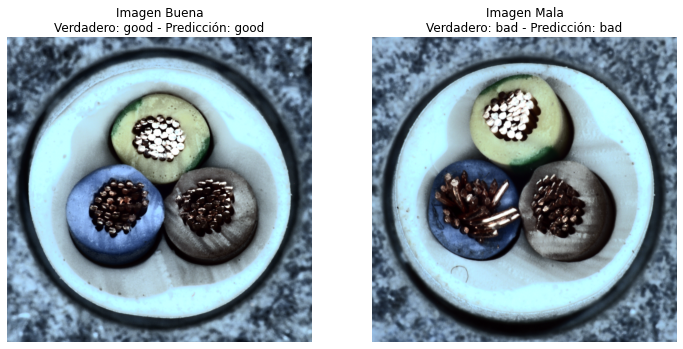

In [55]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Seleccionar el modelo a usar para la predicción (por ejemplo, XGBoost)
model = best_models['xgb']

# Buscar el primer índice donde la etiqueta verdadera es "good" y otro donde es "bad"
good_idx = None
bad_idx = None
for i, label in enumerate(test_labels):
    if good_idx is None and label == 'good':
        good_idx = i
    if bad_idx is None and label == 'bad':
        bad_idx = i
    if good_idx is not None and bad_idx is not None:
        break

if good_idx is None or bad_idx is None:
    print("No se encontraron imágenes de ambas clases.")
else:
    # Realizar las predicciones para ambas imágenes
    good_pred = model.predict([test_data[good_idx]])[0]
    bad_pred = model.predict([test_data[bad_idx]])[0]

    # Usar el LabelEncoder para obtener la etiqueta original de la predicción
    good_pred_label = label_encoder.inverse_transform([good_pred])[0]
    bad_pred_label = label_encoder.inverse_transform([bad_pred])[0]

    # Preparar los títulos para mostrar verdaderos y predichos
    good_title = f"Imagen Buena\nVerdadero: {test_labels[good_idx]} - Predicción: {good_pred_label}"
    bad_title  = f"Imagen Mala\nVerdadero: {test_labels[bad_idx]} - Predicción: {bad_pred_label}"

    # Convertir de BGR a RGB para una visualización correcta con matplotlib
    good_img = cv2.cvtColor(test_data[good_idx], cv2.COLOR_BGR2RGB)
    bad_img = cv2.cvtColor(test_data[bad_idx], cv2.COLOR_BGR2RGB)

    # Mostrar las imágenes
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(good_img)
    plt.title(good_title)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(bad_img)
    plt.title(bad_title)
    plt.axis('off')

    plt.show()

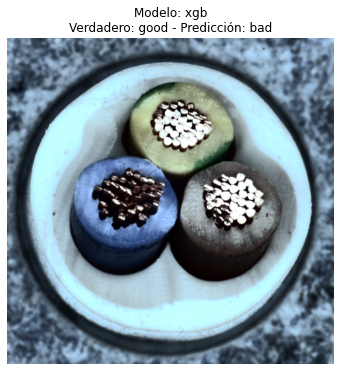

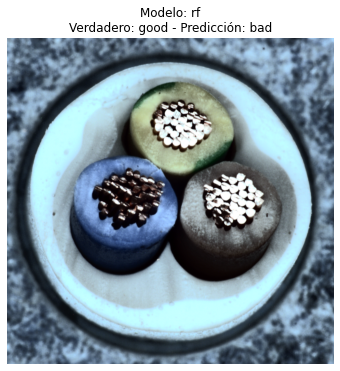

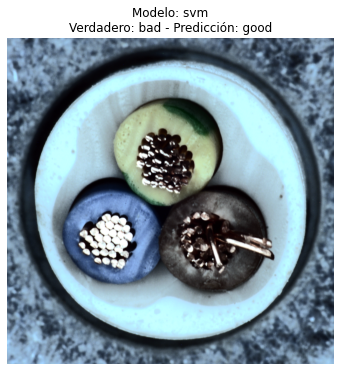

In [56]:
for model_name, model in best_models.items():
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(test_data)
    
    # Encontrar índices donde la predicción es incorrecta
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(encoded_test_labels, y_pred)) if true != pred]
    
    if misclassified_indices:
        idx = misclassified_indices[0]
        true_label = label_encoder.inverse_transform([encoded_test_labels[idx]])[0]
        predicted_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        
        # Convertir la imagen de BGR a RGB para visualización correcta
        img_rgb = cv2.cvtColor(test_data[idx], cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(6,6))
        plt.imshow(img_rgb)
        plt.title(f"Modelo: {model_name}\nVerdadero: {true_label} - Predicción: {predicted_label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"El modelo {model_name} no tiene errores de clasificación en el conjunto de prueba.")

## 5. Análisis de Clasificaciones Incorrectas
---

## Modelo XGB
  El modelo XGB clasificó incorrectamente una instancia de la clase `good` como `bad`. 
  Esto podría deberse a características visuales en la imagen que se asemejan a defectos presentes en la clase `bad`, como texturas o colores oscuros que podrían ser interpretados como defectos.

---

## Modelo RF
  Similar al caso de XGB, el modelo RF también confundió una instancia `good` con `bad`. 
  Esto sugiere que ambos modelos pueden estar influenciados por patrones visuales ambiguos, como la distribución de los colores o texturas que no son representativos de la clase `good`.

---

## Modelo SVM
  En este caso, el modelo SVM clasificó incorrectamente una instancia `bad` como `good`. 
  Esto podría indicar que el modelo tiene dificultades para identificar ciertos defectos visuales, posiblemente debido a una menor capacidad de generalización en comparación con los modelos XGB y RF.
  Es posible que los defectos en esta imagen no sean suficientemente prominentes o que se asemejen a características de las imágenes de la clase `good`.

---
## Conclusión

**XGB** y **RF** tienden a confundir instancias `good` como `bad`, lo que podría deberse a una sensibilidad excesiva a ciertos patrones visuales que no representan defectos reales.
**SVM**, por otro lado, tiene problemas para identificar correctamente las instancias `bad`, clasificándolas como `good`, lo que sugiere que tiene dificultades para detectar defectos más sutiles.

## Entrenamiento con random search

In [ ]:
# Codificar etiquetas numéricamente
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# --- Clases para la extracción de características ---
class SIFTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sift = cv2.SIFT_create()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        descriptors_list = []
        for img in X:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, descriptors = self.sift.detectAndCompute(gray, None)
            if descriptors is not None:
                descriptors_list.append(descriptors)
        return descriptors_list

class VisualVocabulary(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=100):
        self.n_clusters = n_clusters
        self.kmeans = None
    def fit(self, X, y=None):
        all_descriptors = np.vstack(X)
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(all_descriptors)
        return self
    def transform(self, X):
        histograms = []
        for descriptors in X:
            if descriptors is not None:
                words = self.kmeans.predict(descriptors)
                histogram, _ = np.histogram(words, bins=np.arange(self.n_clusters + 1))
                histograms.append(histogram)
            else:
                histograms.append(np.zeros(self.n_clusters))
        return np.array(histograms)

# --- Modelos a probar ---
models = {
    'xgb': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'svm': SVC(probability=True, random_state=42)
}

# --- Grids de hiperparámetros específicos para cada modelo ---
param_grids = {
    'xgb': {
        'vocabulary__n_clusters': [50, 100, 150, 200],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0]
    },
    'rf': {
        'vocabulary__n_clusters': [50, 100, 150, 200],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7]
    },
    'svm': {
        'vocabulary__n_clusters': [50, 100, 150, 200],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

best_models = {}

# --- Pipeline y RandomizedSearchCV para cada modelo ---
for name, clf in models.items():
    print(f"\nProbando modelo: {name}")
    pipeline = Pipeline([
        ('sift_extractor', SIFTFeatureExtractor()),
        ('vocabulary', VisualVocabulary(n_clusters=100)),
        ('tfidf', TfidfTransformer()),
        ('scaler', StandardScaler(with_mean=False)),  # Evitar error en datos dispersos
        ('classifier', clf)
    ])
    
    param_distributions = param_grids[name]
    
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=10,
        cv=3,
        scoring='accuracy',
        random_state=42,
        verbose=2
    )
    
    # Ajustar RandomizedSearchCV usando las etiquetas codificadas
    random_search.fit(train_data, encoded_train_labels)
    
    best_model = random_search.best_estimator_
    best_models[name] = best_model
    accuracy = best_model.score(test_data, encoded_test_labels)
    print(f"Mejor precisión para {name}: {accuracy:.2f}")
    print(f"Mejores hiperparámetros para {name}: {random_search.best_params_}")
    print("Resultados de todas las iteraciones:")
    for mean_score, params in zip(random_search.cv_results_['mean_test_score'],
                                  random_search.cv_results_['params']):
        print("Métrica:", mean_score, "- Parámetros:", params)

## Referencias

Paul Bergmann, Kilian Batzner, Michael Fauser, David Sattlegger, Carsten Steger: The MVTec Anomaly Detection Dataset: A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: International Journal of Computer Vision 129(4):1038-1059, 2021, DOI: 10.1007/s11263-020-01400-4.

Paul Bergmann, Michael Fauser, David Sattlegger, Carsten Steger: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 9584-9592, 2019, DOI: 10.1109/CVPR.2019.00982.